# Anomaly Detection - Isolation Forests

### Data Mining Project 2024/25

Authors: Nicola Emmolo, Simone Marzeddu, Jacopo Raffi

In [17]:
from sklearn.ensemble import IsolationForest

import seaborn
from scipy.spatial.distance import pdist, squareform

import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

In [18]:
cyclists_dataset = pd.read_csv('../data/cyclists_dataset_fe.csv', dtype={'cyclist_team': str})
cyclists_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6095 entries, 0 to 6094
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cyclist_url      6095 non-null   object 
 1   mean_cyclist_cp  5011 non-null   float64
 2   mean_delta       6095 non-null   float64
 3   mean_position    6095 non-null   float64
 4   birth_year       6095 non-null   int64  
 5   weight           3134 non-null   float64
 6   height           3134 non-null   float64
 7   nationality      6095 non-null   object 
 8   cyclist_name     6095 non-null   object 
 9   cyclist_bmi      3134 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 476.3+ KB


In [ ]:
RANDOM_STATE = 42

In [19]:
races_dataset = pd.read_csv('../data/races_dataset_fe.csv')
races_dataset['date'] = pd.to_datetime(races_dataset['date'], format='%Y-%m-%d')
races_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5281 entries, 0 to 5280
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   race_url              5281 non-null   object        
 1   race_name             5281 non-null   object        
 2   points                5281 non-null   float64       
 3   uci_points            2780 non-null   float64       
 4   length                5281 non-null   float64       
 5   climb_total           3326 non-null   float64       
 6   profile               3326 non-null   float64       
 7   startlist_quality     5281 non-null   int64         
 8   date                  5281 non-null   datetime64[ns]
 9   mostly_tarmac         5281 non-null   bool          
 10  race_year             5281 non-null   int64         
 11  race_stage            5281 non-null   object        
 12  race_season           5281 non-null   object        
 13  climb_percentage  

In [20]:
complete_dataset = pd.read_csv('../data/complete_dataset_fe.csv', dtype={'cyclist_team': str})
complete_dataset['date'] = pd.to_datetime(complete_dataset['date'], format='%Y-%m-%d')
complete_dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589739 entries, 0 to 589738
Data columns (total 38 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   cyclist_url                  589739 non-null  object        
 1   cyclist_name                 589739 non-null  object        
 2   birth_year                   589739 non-null  int64         
 3   weight                       480007 non-null  float64       
 4   height                       480007 non-null  float64       
 5   nationality                  589739 non-null  object        
 6   race_url                     589739 non-null  object        
 7   race_name                    589739 non-null  object        
 8   points                       589739 non-null  float64       
 9   uci_points                   422184 non-null  float64       
 10  length                       589739 non-null  float64       
 11  climb_total               

## Anomaly Detection - Cyclists Dataset

<class 'pandas.core.frame.DataFrame'>
Index: 3060 entries, 0 to 6093
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mean_cyclist_cp  3060 non-null   float64
 1   mean_delta       3060 non-null   float64
 2   mean_position    3060 non-null   float64
 3   birth_year       3060 non-null   int64  
 4   weight           3060 non-null   float64
 5   height           3060 non-null   float64
 6   cyclist_bmi      3060 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 191.2 KB


<Axes: >

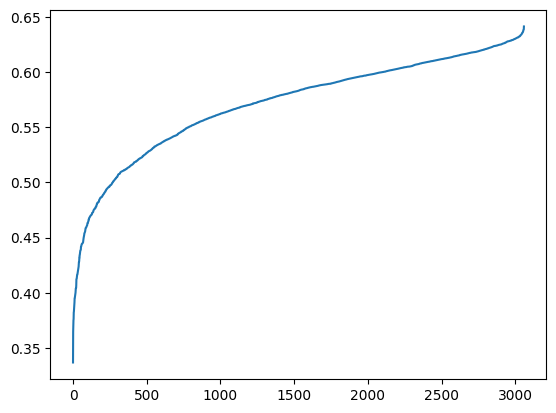

In [21]:
# Filter the dataset to keep only numeric and non-NaN rows
numeric_dataset = cyclists_dataset.select_dtypes(include=['number'])
numeric_dataset = numeric_dataset.dropna()
numeric_dataset.info()

max_features = numeric_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features, random_state=RANDOM_STATE)
algorithm.fit(numeric_dataset)

# Calculate outlier degrees and scores
outlier_degrees = algorithm.decision_function(numeric_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(numeric_dataset) + 1) / 2

# Combine with original dataset
dataset_with_outlier_scores = cyclists_dataset.copy()

# Initialize the new columns with NaN to match the original dataset's length
dataset_with_outlier_scores["isolation_forest_degree"] = float("nan")
dataset_with_outlier_scores["isolation_forest_scores"] = float("nan")

# Assign outlier scores only to the rows used in numeric_dataset
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_degree"] = outlier_degrees
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_scores"] = outlier_scores

# Plot sorted outlier degrees, with x matching its length
sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(len(sorted_outlier_degrees)),  # x-axis matches the length of sorted_outlier_degrees
    y=sorted_outlier_degrees
)

The outlier_degrees array provides a measure of how far each sample is from the decision boundary (the value is normalized):
- Close to 1: More likely to be an inlier.
- Close to 0: More likely to be an outlier.


The outlier_scores array represents a "binarized likelihood" of each data point being an outlier (scores values are 0 or 1):
- 1: More likely to be an outlier.
- 0: More likely to be an inlier.

In [22]:
degree_threshold = 0.5

# Combine thresholds for outlier detection
dataset_with_outlier_scores["is_outlier"] = (
    (dataset_with_outlier_scores["isolation_forest_scores"] == 1) &
    (dataset_with_outlier_scores["isolation_forest_degree"] < degree_threshold)
)

len(dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1])

269

In [23]:
anomalies = dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1]

anomalies.describe()

,mean_cyclist_cp,mean_delta,mean_position,birth_year,weight,height,cyclist_bmi,isolation_forest_degree,isolation_forest_scores
count,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.0
mean,0.010126,570.852931,0.543302,1976.710037,70.258736,178.828996,21.905311,0.463712,1.0
std,0.021077,749.727716,0.236369,18.713809,10.283212,9.850398,2.160005,0.032162,0.0
min,0.000001,3.000000,0.044118,1940.000000,48.000000,154.000000,16.412069,0.336932,1.0
25%,0.000176,171.593220,0.344289,1961.000000,63.000000,172.000000,20.371209,0.445656,1.0
50%,0.001705,360.000000,0.529709,1981.000000,70.000000,178.000000,22.058051,0.472869,1.0
75%,0.006503,724.800000,0.718749,1992.000000,78.000000,186.000000,23.355637,0.488242,1.0
max,0.151771,7291.800000,1.000000,2004.000000,94.000000,204.000000,27.770313,0.499853,1.0


In [24]:
# The outliers found are now filtered from the dataset
dataset_with_outlier_scores = dataset_with_outlier_scores[dataset_with_outlier_scores['is_outlier'] != 1]

# Remove specified columns (used just during computation and analysis)
columns_to_remove = ['isolation_forest_scores', 'isolation_forest_degree', 'is_outlier']
final_dataset = dataset_with_outlier_scores.drop(columns=columns_to_remove)

# The dataset is now saved in csv format
final_dataset.to_csv('../data/cyclists_dataset_no_outliers.csv', index=False)

## Anomaly Detection - Races Dataset

<class 'pandas.core.frame.DataFrame'>
Index: 2384 entries, 58 to 4927
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   points                2384 non-null   float64
 1   uci_points            2384 non-null   float64
 2   length                2384 non-null   float64
 3   climb_total           2384 non-null   float64
 4   profile               2384 non-null   float64
 5   startlist_quality     2384 non-null   int64  
 6   race_year             2384 non-null   int64  
 7   climb_percentage      2384 non-null   float64
 8   race_physical_effort  2384 non-null   float64
 9   race_prestige         2384 non-null   float64
 10  num_participants      2384 non-null   int64  
dtypes: float64(8), int64(3)
memory usage: 223.5 KB


<Axes: >

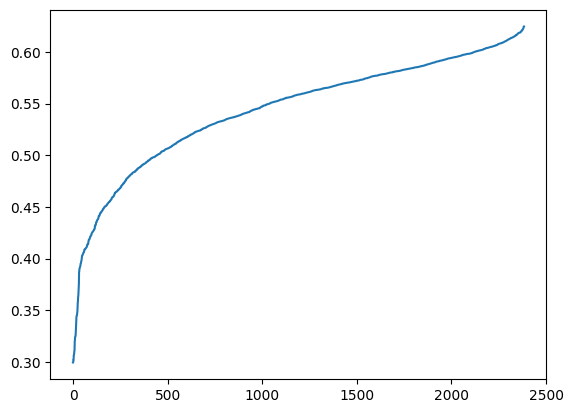

In [25]:
# Filter the dataset to keep only numeric and non-NaN rows
numeric_dataset = races_dataset.select_dtypes(include=['number'])
numeric_dataset = numeric_dataset.dropna()
numeric_dataset.info()

max_features = numeric_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features, random_state=RANDOM_STATE)
algorithm.fit(numeric_dataset)

# Calculate outlier degrees and scores
outlier_degrees = algorithm.decision_function(numeric_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(numeric_dataset) + 1) / 2

# Combine with original dataset
dataset_with_outlier_scores = races_dataset.copy()

# Initialize the new columns with NaN to match the original dataset's length
dataset_with_outlier_scores["isolation_forest_degree"] = float("nan")
dataset_with_outlier_scores["isolation_forest_scores"] = float("nan")

# Assign outlier scores only to the rows used in numeric_dataset
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_degree"] = outlier_degrees
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_scores"] = outlier_scores

# Plot sorted outlier degrees, with x matching its length
sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(len(sorted_outlier_degrees)),  # x-axis matches the length of sorted_outlier_degrees
    y=sorted_outlier_degrees
)

The outlier_degrees array provides a measure of how far each sample is from the decision boundary (the value is normalized):
- Close to 1: More likely to be an inlier.
- Close to 0: More likely to be an outlier.


The outlier_scores array represents a "binarized likelihood" of each data point being an outlier (scores values are 0 or 1):
- 1: More likely to be an outlier.
- 0: More likely to be an inlier.

In [26]:
degree_threshold = 0.5

# Combine thresholds for outlier detection
dataset_with_outlier_scores["is_outlier"] = (
    (dataset_with_outlier_scores["isolation_forest_scores"] == 1) &
    (dataset_with_outlier_scores["isolation_forest_degree"] < degree_threshold)
)

len(dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1])

444

In [27]:
anomalies = dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1]

anomalies.describe()

,points,uci_points,length,climb_total,profile,startlist_quality,date,race_year,climb_percentage,race_physical_effort,race_prestige,num_participants,isolation_forest_degree,isolation_forest_scores
count,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.0
mean,167.815315,266.234234,176.751396,2.821083,2.869369,1062.765766,2013-02-13 02:55:08.108108032,2012.677928,0.032254,0.204215,0.274045,127.576577,0.451232,1.0
min,20.000000,6.000000,1.900000,0.006000,1.000000,156.000000,2001-03-03 00:00:00,2001.000000,0.000652,0.000004,0.000000,1.000000,0.299494,1.0
25%,80.000000,20.000000,142.900000,1.330000,2.000000,769.250000,2007-04-02 18:00:00,2007.000000,0.008415,0.037614,0.129454,99.750000,0.427801,1.0
50%,125.000000,210.000000,201.600000,2.972500,2.000000,972.500000,2013-07-17 12:00:00,2013.000000,0.016279,0.163667,0.266942,127.000000,0.463594,1.0
75%,275.000000,500.000000,245.250000,4.149250,5.000000,1465.750000,2019-03-24 12:00:00,2019.000000,0.025219,0.265108,0.355603,160.000000,0.485069,1.0
max,350.000000,800.000000,305.000000,6.939000,5.000000,1812.000000,2023-07-29 00:00:00,2023.000000,1.229474,0.895288,0.908128,198.000000,0.499916,1.0
std,94.224060,217.101674,86.721787,1.700458,1.473945,408.112612,NaN,6.973498,0.096673,0.199027,0.167689,38.943276,0.044323,0.0


In [28]:
# The outliers found are now filtered from the dataset
dataset_with_outlier_scores = dataset_with_outlier_scores[dataset_with_outlier_scores['is_outlier'] != 1]

# Remove specified columns (used just during computation and analysis)
columns_to_remove = ['isolation_forest_scores', 'isolation_forest_degree', 'is_outlier']
final_dataset = dataset_with_outlier_scores.drop(columns=columns_to_remove)

# The dataset is now saved in csv format
final_dataset.to_csv('../data/races_dataset_no_outliers.csv', index=False)

## Anomaly Detection - Cyclist + Races Merged Dataset

<class 'pandas.core.frame.DataFrame'>
Index: 348047 entries, 59 to 589737
Data columns (total 27 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   birth_year                   348047 non-null  int64  
 1   weight                       348047 non-null  float64
 2   height                       348047 non-null  float64
 3   points                       348047 non-null  float64
 4   uci_points                   348047 non-null  float64
 5   length                       348047 non-null  float64
 6   climb_total                  348047 non-null  float64
 7   profile                      348047 non-null  float64
 8   startlist_quality            348047 non-null  int64  
 9   position                     348047 non-null  float64
 10  cyclist_age                  348047 non-null  int64  
 11  delta                        348047 non-null  float64
 12  race_year                    348047 non-null  int64  
 13  raw

<Axes: >

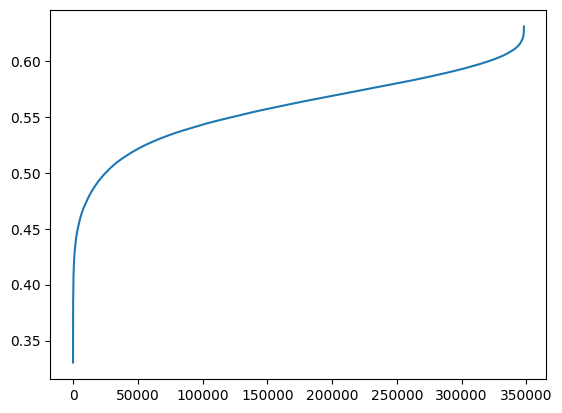

In [29]:
# Filter the dataset to keep only numeric and non-NaN rows
numeric_dataset = complete_dataset.select_dtypes(include=['number'])
numeric_dataset = numeric_dataset.dropna()
numeric_dataset.info()

max_features = numeric_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features, random_state=RANDOM_STATE)
algorithm.fit(numeric_dataset)

# Calculate outlier degrees and scores
outlier_degrees = algorithm.decision_function(numeric_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(numeric_dataset) + 1) / 2

# Combine with original dataset
dataset_with_outlier_scores = complete_dataset.copy()

# Initialize the new columns with NaN to match the original dataset's length
dataset_with_outlier_scores["isolation_forest_degree"] = float("nan")
dataset_with_outlier_scores["isolation_forest_scores"] = float("nan")

# Assign outlier scores only to the rows used in numeric_dataset
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_degree"] = outlier_degrees
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_scores"] = outlier_scores

# Plot sorted outlier degrees, with x matching its length
sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(len(sorted_outlier_degrees)),  # x-axis matches the length of sorted_outlier_degrees
    y=sorted_outlier_degrees
)

The outlier_degrees array provides a measure of how far each sample is from the decision boundary (the value is normalized):
- Close to 1: More likely to be an inlier.
- Close to 0: More likely to be an outlier.


The outlier_scores array represents a "binarized likelihood" of each data point being an outlier (scores values are 0 or 1):
- 1: More likely to be an outlier.
- 0: More likely to be an inlier.

In [30]:
degree_threshold = 0.5

# Combine thresholds for outlier detection
dataset_with_outlier_scores["is_outlier"] = (
    (dataset_with_outlier_scores["isolation_forest_scores"] == 1) &
    (dataset_with_outlier_scores["isolation_forest_degree"] < degree_threshold)
)

len(dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1])

25185

In [31]:
anomalies = dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1]

anomalies.describe()

,birth_year,weight,height,points,uci_points,length,climb_total,profile,startlist_quality,date,...,mean_cyclist_cp,mean_delta,mean_position,previous_mean_position,previous_mean_delta,previous_mean_cp,cyclist_previous_experience,num_participants,isolation_forest_degree,isolation_forest_scores
count,25185.000000,25185.000000,25185.000000,25185.000000,25185.000000,25185.000000,25185.000000,25185.000000,25185.000000,25185,...,25185.000000,25185.000000,25185.000000,25185.000000,25185.000000,25185.000000,25185.000000,25185.000000,25185.000000,25185.0
mean,1983.233313,69.469934,180.550328,179.007743,286.048164,203.045180,2.978768,2.766170,1078.685527,2013-09-08 17:25:39.058963456,...,0.013814,501.474839,0.482978,0.485256,509.683695,0.017750,0.343639,137.098789,0.473784,1.0
min,1963.000000,48.000000,158.000000,20.000000,6.000000,1.150000,0.002000,1.000000,156.000000,2001-03-03 00:00:00,...,0.000006,38.142857,0.086467,0.008065,0.000000,0.000002,0.000185,30.000000,0.330425,1.0
25%,1978.000000,64.000000,176.000000,80.000000,20.000000,179.000000,1.926000,2.000000,835.000000,2008-09-17 00:00:00,...,0.001327,282.246787,0.348175,0.353135,262.476562,0.001126,0.088286,107.000000,0.462340,1.0
50%,1983.000000,70.000000,181.000000,225.000000,400.000000,219.000000,3.042000,2.000000,1026.000000,2014-03-23 00:00:00,...,0.003348,475.895317,0.485015,0.483406,438.177331,0.002796,0.273342,143.000000,0.479662,1.0
75%,1989.000000,75.000000,185.000000,275.000000,500.000000,257.500000,4.150000,4.000000,1249.000000,2018-09-05 00:00:00,...,0.013621,639.975543,0.603744,0.610702,612.103093,0.012579,0.545701,167.000000,0.491292,1.0
max,2004.000000,94.000000,204.000000,350.000000,800.000000,305.000000,6.939000,5.000000,1812.000000,2023-07-29 00:00:00,...,0.151771,7291.800000,0.988328,0.995968,13027.500000,0.571432,1.000000,206.000000,0.499998,1.0
std,8.134162,7.380781,6.954907,102.505705,242.315113,75.001068,1.508673,1.464315,342.653770,NaN,...,0.023563,317.728574,0.168553,0.173411,461.104289,0.039369,0.288650,36.632381,0.022674,0.0


In [32]:
# The outliers found are now filtered from the dataset
dataset_with_outlier_scores = dataset_with_outlier_scores[dataset_with_outlier_scores['is_outlier'] != 1]

# Remove specified columns (used just during computation and analysis)
columns_to_remove = ['isolation_forest_scores', 'isolation_forest_degree', 'is_outlier']
final_dataset = dataset_with_outlier_scores.drop(columns=columns_to_remove)

# The dataset is now saved in csv format
final_dataset.to_csv('../data/complete_dataset_no_outliers.csv', index=False)